  Basic text printing on NumPy image
  --------------------------------------------------
 We will construct basic fonts with scikit-image.
 Afterwards they will be used to provide a NumPy only basic image annotation tool.  
   
 *No openCV or Pillow needed!*
 
   
---

 
 ## I - Font as images
 
  For demonstration purposes, we import brutally a font from a picture.
  We use a few characters of the AnjaliOldLipi font.  
  Copyright of AnjaliOldLipi font: Credit to Kevin & Siji, 2004. No rights reserved.  
  The picture was taken as a screen print of a LibreOffice window.


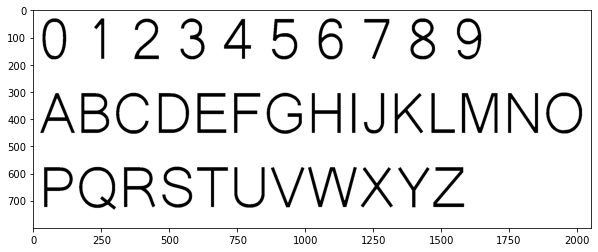

In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt


my_font = skimage.io.imread('anjali_old_lipi.png',as_gray=True)
my_font = (my_font==0)[:800]

my_alphabet = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def plot_page(page,cmap='gray_r'):
    plt.figure(figsize=(10,10))
    plt.imshow(page,cmap=cmap)
plot_page(my_font)


In [2]:

def bounding_box(character):
    x_max = np.amax(np.where(character)[1])
    x_min = np.amin(np.where(character)[1])
    y_max = np.amax(np.where(character)[0])
    y_min = np.amin(np.where(character)[0])
    
    return character[y_min:y_max+1,x_min:x_max+1]



Here we can easily label the various characters as the connected components of the front part of our binary image. Moreover, in this example all the characters in a line of text will have there lowest points aligned.
In general, this is not the adequate alignment.  
  
Finer character extraction procedures will be proposed in my handwritten text parsing project.

In [3]:
labels=skimage.measure.label(my_font)

# We reorder the components so that they are correctly numbered, from left to right.

new_labels = np.zeros(labels.shape,dtype='uint8')
x = []
y = []
L=list(range(1,np.amax(labels)+1))
for i in L:
    projection1 = np.sum(labels==i,axis=0)>0
    projection2 = np.sum(labels==i,axis=1)>0
    x_min = np.amin(np.where(projection1))
    x.append(x_min//20)
    y_min = np.amin(np.where(projection2))
    y.append(y_min//20)
L.sort(key = lambda i:(y[i-1],x[i-1]))

j=0
for i in L:
    j+=1
    new_labels+=(labels==i).astype('uint8')*j
labels=new_labels    

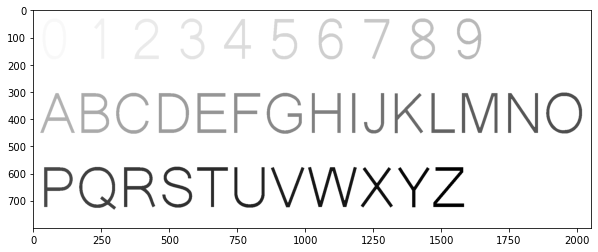

In [4]:
plot_page(labels)

We check the width of a blank space.

In [5]:
for i in range(1,10):
    x_0 = np.amax(np.where(labels==i)[1])
    x_1 = np.amin(np.where(labels==i+1)[1])
    print(x_1-x_0)

104
112
81
73
78
80
81
79
82


The median value seems to be arround 80 in our case. We will set a blank space character accordingly.  
We store the characters' images in a dictionary. 

In [6]:
characters_as_images={}
for i in range(1,np.amax(labels)+1):
    characters_as_images[my_alphabet[i-1]]=bounding_box(labels==i)
characters_as_images[' ']=np.zeros((1,80))

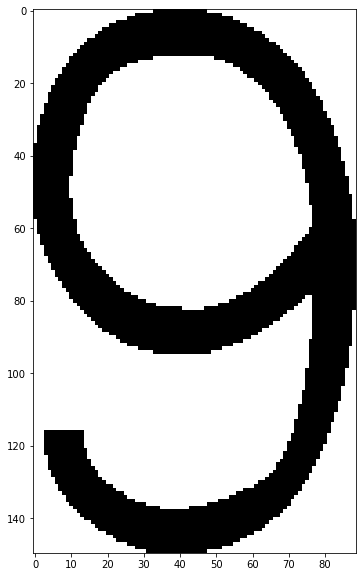

In [7]:
plot_page(characters_as_images['9'])

We store these images to files, for further use.

In [8]:
for key in characters_as_images:
    if key != ' ':
        skimage.io.imsave(key+'.png',(1-characters_as_images[key]).astype('uint8')*255)
    else:
        skimage.io.imsave('_.png',(1-characters_as_images[key]).astype('uint8')*255)

/tmp/ipykernel_16727/2397194184.py:3: UserWarning: I.png is a low contrast image
  skimage.io.imsave(key+'.png',(1-characters_as_images[key]).astype('uint8')*255)
/tmp/ipykernel_16727/2397194184.py:5: UserWarning: _.png is a low contrast image
  skimage.io.imsave('_.png',(1-characters_as_images[key]).astype('uint8')*255)


---
## II - A basic image annotation tool  
We can now use our alphabet to write text.


In [9]:
characters_as_images={}
characters_as_images[' '] = skimage.io.imread('_.png',as_gray=True).astype('bool')
for c in my_alphabet:
    characters_as_images[c] = skimage.io.imread(c+'.png',as_gray=True).astype('bool')

    
# This will be convenient to have all characters of the exact same height and to have a
# small white margin on the left of all characters.

max_height = max(characters_as_images[c].shape[0] for c in characters_as_images)
max_width = max(characters_as_images[c].shape[1] for c in characters_as_images)

for c in characters_as_images:
    shape_ = characters_as_images[c].shape
    characters_as_images[c]=np.vstack([np.ones((max_height-shape_[0],shape_[1]),dtype='bool'),
                                       characters_as_images[c]])
    characters_as_images[c]=np.hstack([characters_as_images[c],
                                       np.ones((max_height,max_width//10+1),dtype='bool')])



def string_to_image(s,relative_line_spacing=0.1):
    if not s:
        print('The input string is empty, returning None.')
        return None
    else:
        lines = s.split('\n')
        image_lines = []
        max_width = 0
        
        for line in lines:
            image_lines.append(np.hstack([characters_as_images[c] for c in line]))
            max_width = max(max_width, image_lines[-1].shape[1])
            
        for i in range(len(image_lines)):
            line = image_lines[i]
            height,width = line.shape
            line_spacing = int(height*relative_line_spacing)
            image_lines[i] = np.hstack([line,np.ones((height,max_width-width),dtype='bool')])
            
            if i != len(image_lines)-1:
                line = image_lines[i]
                image_lines[i] = np.vstack([line,np.ones((line_spacing,max_width),dtype='bool')])
        
        return np.vstack(image_lines)


# Below, the colors are supposed to be given as rgb triples.

def annotated_image(image,text,x,y,relative_size=.1,color=(0,0,0),
                    background_color=None,relative_padding=.05):
    
    text_image = (1-string_to_image(text)).astype('bool')
    text_height = image.shape[0]*relative_size
    scaling_factor = text_height/text_image.shape[0]
    text_image = skimage.transform.rescale(text_image,scaling_factor)

    height,width = text_image.shape
    padding = int(height*relative_padding)
    
    if len(image.shape) != 3:
        new_image = skimage.color.gray2rgb(image)
    else:
        new_image = image.copy()
    
    text_mask = np.zeros(new_image.shape[:2],dtype='bool')
    text_mask[y:y+height,x:x+width]=text_image


    if background_color:
            new_image[y-padding:y+height+padding,x-padding:x+width+padding] = np.array(background_color)
            
    new_image[text_mask] = np.array(color)
    
    return new_image


Let us check a few examples.

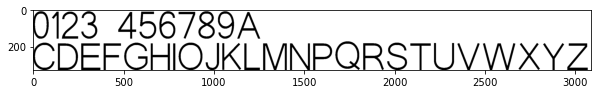

In [10]:
test=string_to_image('0123 456789A\nCDEFGHIOJKLMNPQRSTUVWXYZ')
plot_page(test,cmap='gray')

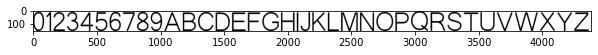

In [11]:
test=string_to_image(my_alphabet)
plot_page(test,cmap='gray')

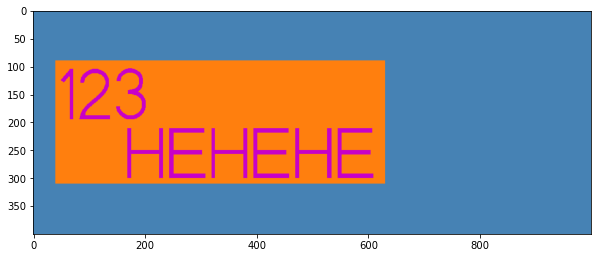

In [12]:
blue_frame = np.zeros((400,1000,3),dtype='uint8')
blue_frame[:] = np.array([70,130,180])
decorated_frame = annotated_image(blue_frame, "123\n  HEHEHE",
                                50,100,color=(200,0,200),relative_size=.5,background_color=(255,127,14))
plot_page(decorated_frame)

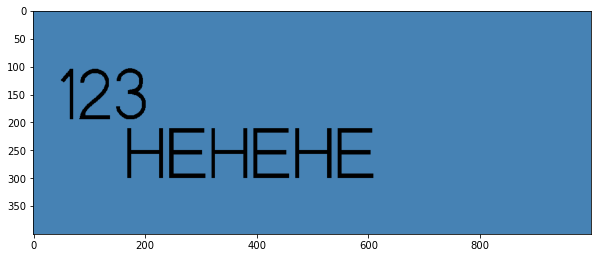

In [13]:
blue_frame = np.zeros((400,1000,3),dtype='uint8')
blue_frame[:] = np.array([70,130,180])
decorated_frame = annotated_image(blue_frame, '123\n  HEHEHE',
                                50,100,relative_size=.5)
plot_page(decorated_frame)

---
## III - Conclusion

Thank you for watching ! If you liked the project, consider giving me a star on GitHub.
